# Class Statudio : Take 2.718🎬🎬

Description:
====
An instance of class OnSource begins by constructing multiple random waveform datasets, alongside known waveforms spanning a provided parameter space. Afterwards, it computes the cross-correlation and chi-square statistics between all dataset and wave template pairs, organizes the output into a dictory, and saves said dictionary into 'outputfile.json' within the current directory.

Current Issue:
====
- The dictrionary seems to be to large to directly save through the notebook; so i've commented it out. The saving feature seems to work fine from my computer though.
- The codes big, and needs to be commented better; I should probably make a write up for the methods too
- I should proabably parallelize the code with ray
- I need to be read the code for 'unknown unknown' errors
- I should see if I can speed anything up with numpy anywhere
- Off topic, but I still don't know why the below 'methods' section doesn't display tables properly
- the 'exec()' functions could almost surely be used to streamline inputing test statistics/ test waveforms into the function

Methods:
====
1. Constructor: 
 - inputs:
    Most of the constructors inputs are to help define the parameter space and waveform intervals...
   
    eng. name | lower bound | upper bound| divison 
    ------------ | ------------- | ------------- | -------------
    Amplitude | A0 | Af | N_A
    Frequency | F0 | Ff | N_f
    Gamma | g0 | gf | N_g
    Noise interval|  | T | N_t
 
 <br>
    Outside of the above, we also have...
    
    \# of data trials | noise amplitude | foreground/background half-widths | template width |
    ------------ | ------------- | ------------- | -------------
    trials | b | d | t0_tf
    
 - outputs:
     see class description





2. waveform: 
generates a dataset of noise + injected waveform; the injected waveform has freqeuncy, amplitude, gamma and start time t0 selected randomly from the parameter space. Really just used to construct the required datasets used in the constructor class
 - inputs:
 
    noise amplitude | interval length | phase | divisions
    ------------- | ------------- | ------------- | -------------
    b | d_end_t | phi | N (=N_t)

 - outputs:
 
     random parameters | time-step  | time array | dataset waveform
    ------------- | ------------- | ------------- | -------------
    \[f, A, $\gamma$, t_RAN \] | dt | T_full | d




3. template:
Produces a template given a position in parameter space
 - inputs:
 
    amplitude | frequency | gamma | interval length | time-step
    ------------- | ------------- | ------------- | ------------- | -------------
    A | f | gamma | duration | dt

 - outputs:
 
     template np array |
    ------------- | 
     A * np.sin(w*t)*np.exp(-gamma*t) |
    
    
    
4. CrossCorrelation
Produces a cross corelation function given a data input and a template in parameter space
 - inputs:
 
    data | template | time-step
    ------------- | ------------- | -------------
    data | template | dt

 - outputs:
 
     cross correlation |
    ------------- | 
     M |

                                            
    
  
5. ChiSquare: 
Produces chi square at each "slide"
 - inputs:
 
    data | template | time-step
    ------------- | ------------- | -------------
    data | template | dt

 - outputs:
 
     chi cquare |
    ------------- | 
     C |


6. Rho:
builds provided test-statistic internally

7. modulator:
performs windowing on a given input

8. window:
performs windowing on the internally stored test statistic values
also builds foreground/ background values, and stores them internally as well

9. test_plotter:
plots threshold vs. success-count
T: threshold range
N: Number of divisions of threshold region
var1, var2 : index of variables to be plotted (0=A, 1=f, 2=g)
bg_test : boolean kwarg; includes/discludes 'on source greater than max noise' condition

10. Scatter_plotter:
plots pass /fails of the threshold condition 
thrshld: threshold value to clear
xvar, yvar : index of variables to be plotted

11. heatmap
plots a heat map of 
    - avg. rhos per choice of two index
    - max background value per template per choice of two index 
    
T : threshold value (all lower values mapped to black)
max_OS : sets value of 'white' in avg rho plots; max OS by default
max_BG : sets value of 'white' in max background plots; max BG by default 



# Actual Code

In [767]:
import json
import numpy as np
from matplotlib import pyplot as plt
%matplotlib inline
import math
import time

class Statudio:
    
    def __init__(self, N_A, N_g, N_f, t0_tf, T, b, D, trials, A0=1, Af=50, g0=0, gf=2, F0=90, Ff=110, N_t=1000):
       
        print('very start...')
        """
        METHOD: 
        Generates a set of wave templates spanning the parameter space of amplitude, frequency and gamma;
        Generates a set of datasets with injected signals via random A, f, gamma, and start time
        Creates cross-correlation/chi-squared stats with the above
        Lastly, saves the above internally as attributes, and externally as a .json file
        
        PARAMETERS:
        -----------
        N_A: divisions in amplitude
        N_g:  divisions in gamma
        N_f: divisions in frequency
        t0_tf: length of template interval [t0, tf] in time
        T: length of total time series, in units of time
        b: noise amplitude
        D: foreground/background interval length
        trials: number of random data sets generated
        A0, Af : amplitude lower/upper bounds
        g0, gf : gamma lower/upper bounds
        F0, ff : frequency lower/upper bounds
        N_t= divisions in total time series 
        
        OUTPUT: Returns global maximum values for given ranges, and produces txt
        value containing all of them
        """
        
        
        print('initalizing output...')
        """initalizes a dictionary of arrays to hold info and later save as a .json
        key i: returns an array of arrays containing datset i and other relavent values
                component 0: true A, f, g & t0 corresoponding to dataset i
                component 1: dataset i
                component 2: cross corelations between dataset and each template
                component 3: chi squares between dataset and each template
        """
        self.trials=trials
        output={}
        for i in range(self.trials):
            output.update({i:[[],[],[],[]]})
        
        
        
        print('initalizing attributes...')
        # initalizes the arrays which span parameter space, and their lengths
        self.A_RANGE=np.linspace(A0,Af,N_A)
        self.G_RANGE=np.linspace(g0,gf,N_g)
        self.F_RANGE=np.linspace(F0,Ff,N_f)
        
        self.A_LEN, self.G_LEN, self.F_LEN = len(self.A_RANGE), len(self.G_RANGE), len(self.F_RANGE)
        
        self.N=N_t
        
        # Constructs timestep resolution, and saves t0/tf internally 
        self.dt, self.t0_tf= T/N_t, t0_tf
        
        # constructs time range to pick injected signal start time from/ corresponding length 
        self.t_RANGE=np.linspace(0,T-(t0_tf),int(N_t*(1-((t0_tf)/(T)))))
        self.t_LEN=len(self.t_RANGE)

        # initialize arrays for various data/cross-correlations/chi-squares 
        self.noise = []
        self.cross_cor=[]
        self.chi=[]
        
        
        
        print('building pairs/templates...')
        # constructs all templates which correspond to points in the parameter space
        self.TEMPLATES_AFG=[ self.template( A, f, g, t0_tf, self.dt) for A in self.A_RANGE 
                       for g in self.G_RANGE for f in self.F_RANGE]
        
        self.AFG_PAIR=[ [A, f, g] for A in self.A_RANGE 
                       for g in self.G_RANGE for f in self.F_RANGE]
       
    
    
        print('starting data/template loop...')
        for i in range(trials):            
            
            # generates data
            temp_AFGT, data = self.waveform(N_t, T, t0_tf, b)
            
            self.noise.append(data) 
            output[i][0], output[i][1] = list(temp_AFGT), list(data)  ## stores random a-g-f pair / data set 
            
            
            CRS_COR, CHI_SQR = [[],[]]
            
            # performs base static calculation accross parameter space
            for template in self.TEMPLATES_AFG:
            
                CC_dh=list(self.CrossCorrelation(data, template, self.dt))
                CRS_COR.append(CC_dh)
                                            
                CS_dh=list(self.ChiSquare(data, template, self.dt))
                CHI_SQR.append(CS_dh)
            
            #stores base statistics in appropriate attribute/ output
            self.cross_cor.append(CRS_COR)
            self.chi.append(CHI_SQR)
            output[i][2], output[i][3] = CRS_COR, CHI_SQR
        
        #sets output as a attribute
        self.output=output
        
        #saves 'output' as a .json in current working directory.
        '''with open('outputfile', "w") as f:
            json.dump(output, f, indent=2, sort_keys=True)'''
    
    
    
    
            
    def waveform(self, N, T, t0_tf, B, phi0=0):
    
        #calculates random parameters A, f, g
        A_RAN=np.random.randint(0,self.A_LEN)
        G_RAN=np.random.randint(0,self.G_LEN)
        F_RAN=np.random.randint(0,self.F_LEN)
        
        f, A, gamma = self.F_RANGE[F_RAN], self.A_RANGE[A_RAN],  self.G_RANGE[G_RAN] 
    
        dt=T/N
    

        NOISE = -B+2*B*np.random.random(N)  # Noise!

    
        t0=(T-t0_tf)*np.random.random(1)[0]  # Randomly generate start time
        START_INDEX=math.floor(t0/dt)        # find index associated with time

    
        ##NOTE: using 't0' instead of some multiple of dt may cause issues later
    
        SIG_LEN =( math.floor(t0_tf/dt)+1 if (t0_tf != T) else N )      # Calculate # of indexes signal takes
        INJECTED = np.zeros(N)                       #initalize injected signal
        for i in range(SIG_LEN):
            INJECTED[ START_INDEX + i]=t0+i*dt       #fill in injected signal

        w = 2 * np.pi * f
    
        SR = INJECTED[ START_INDEX : START_INDEX+SIG_LEN][:]
        INJECTED[ START_INDEX : START_INDEX+SIG_LEN] = A*np.sin(w*SR + phi0)*np.exp(-gamma*( SR-t0))
        D_i = NOISE + INJECTED  # Complete Data!
    
        return [A, f, gamma, t0], D_i


    
    
    
    #calculates test statistic, stroes it internally,
    #and returns a copy of it as a dictionary 
    def rho(self):
        #counts number of tempates in parameter space
        PSPACE_LEN=len(self.AFG_PAIR)
    
        #initalizes rho statistic dictionary
        self.RHO={}
    
        #indexed to loops through dataset trials
        for i in range(self.trials):
            rho_i=[]
        
            #indexed to loops through parameter space templates and
            #calculates each rho_ij given template j
            for j in range(PSPACE_LEN):
                CC_IJ=np.array(self.cross_cor[i][j][:])
                CS_IJ=np.array(self.chi[i][j][:])
                
                            ##1. function_input="f(CC,CS)"
                            ##2. exec("p="+function_input)
                            ##3. rho_i.append( list( p )) )
                            ##4. ...
                            ##5. profit?
                            
                rho_i.append( list( (CC_IJ/(1+CS_IJ) )) ) 
            
            self.RHO.update({ i : rho_i })
        return self.RHO

    
    
    
    
    def modulator(self, rho_ij, D):
       
        rho_mod_D, RHO_ij = [] , rho_ij[:]
    
        dn , L = math.floor(2*D/self.dt) , len(RHO_ij)

        for i in range(0,L-(L%dn),dn):
            rho_mod_D.append(max(RHO_ij[i:i+dn]))
        
        if (L-(L%dn)) != L :
            rho_mod_D.append(max(RHO_ij[L-(L%dn):L]))
        
        return rho_mod_D
    
    
    
    
    
    def window(self, D):
        
        if (2*D >= self.dt):
            
            print('initalizing output...')
            """Build a dictionary of arrays that hold rho off-source/on-source values
            key i: returns ndim-arrays containing rho statistics of dataset_i
                component [0][j]: returns off-source array for template j
                component [1][j]: returns on-source scalar for template j
            """
            
            #gets the length of linearized template space
            TEMP_LEN=len(self.cross_cor[0])
            
            self.RHO_MOD={}
            self.MAX_OS={}
            self.MAX_BG_TEMP={}
            
            for j in range(TEMP_LEN):
                self.MAX_BG_TEMP.update({ j : 0})
                
            for i in range(self.trials):
    
                #calculates bg values + fg values
                BG_VALS_IJ=[self.modulator( self.RHO[i][j][:] ,D ) for j in range(TEMP_LEN)]
            
                #seperates fg value from bg value
                T0_2D=math.floor(self.output[i][0][3]/(2*D))
            
                print("t0: "+str(self.output[i][0][3])+"  T0_2D: "+str(T0_2D))
            
                FG_VAL_IJ=[ BG_VALS_IJ[j].pop(T0_2D) for j in range(TEMP_LEN)]
                
                self.RHO_MOD.update({ i: [ BG_VALS_IJ, FG_VAL_IJ ] })
        
                self.MAX_OS.update({ i :[tuple(self.output[i][0][0:3]),max(self.RHO_MOD[i][1])] })
                
                for j in range(TEMP_LEN): 
                    new_max=max(self.RHO_MOD[i][0][j])
                    
                    if (self.MAX_BG_TEMP[j]< new_max):
                        self.MAX_BG_TEMP[j]=new_max
                
                
            return self.RHO_MOD
        
        else: 
            print("invalid D; it is required that 2*D >= T/N")
    
    

    def test_plotter(self, T, N, var1=0, var2=0,bg_test=True):
        
        # Calculates the index of the attribute variable
        # (A, F, or G) which the heat map should marginaliz 
        # over
        if ((var1 <= 2) and (var2 <= 2)):    #checks if range valid
            if ((0<= var1) and (0<= var2)):  #checks if range valid
                if (var2 < var1):            #properly orders
                    var1, var2 = var2, var1
                    index=(1/4)*(var1-1)*(var1-2)*(var2)*(7-3*var2) #maps to needed index
                    
                elif (var2==var1):
                    index=var2  # if the values are the same, set as index
                    
                else:
                    index=(1/4)*(var1-1)*(var1-2)*(var2)*(7-3*var2) #maps to needed index

            else:
                print("improper index inputs: both must be >= 0")
                index=0
        else:
            print("improper index inputs: both must be <= 2")
            index=0
            
             
                
                
        mapping={}   #initalizes mapping for heat map
    
        holder=np.full((self.A_LEN, self.F_LEN, self.G_LEN), 0, dtype=list)
        
        # builds link between keys and np-array 
        for j in range(self.F_LEN):
            for i in range(self.A_LEN):
                for k in range(self.G_LEN):
                    F=self.F_RANGE[j]
                    A=self.A_RANGE[i]
                    G=self.G_RANGE[k]
            
                    holder[(i,j,k)]=[0]
                    mapping.update({ (A,F,G) : holder[(i,j,k)]})
                    
                
        
        #initalizes threshold axis points, counts for each threshold
        #and space of parameter space
        THRS_AXIS=[]
        COUNT_AXIS=[]
        PSPACE_LEN=len(self.AFG_PAIR)
        PSACE_PAIRS=[]

        #sets current threshold value
        for thrshld in np.linspace(0,T,N):

            THRS_AXIS.append(thrshld)
            succ_count_thrhld=0
        
            #loops from trial/ parameter space pairs 
            for i in range(self.trials):
                heat_count=0
                for j in range(PSPACE_LEN):
                
                    RM_ij=np.array(self.RHO_MOD[i][0][j])
                    FG_ij=self.RHO_MOD[i][1][j]
                    N_BG_ij=len(RM_ij[ RM_ij > FG_ij])
                
                    #tests if the given pair passes the threshold test
                    if (bg_test==True):
                        if ((N_BG_ij==0) and (FG_ij > thrshld)):

                            if heat_count==0:
                                succ_count_thrhld+=1
                                mapping[tuple(self.output[i][0][:3])][0]+=1
                                heat_count+=1
                    else:
                        if (FG_ij > thrshld):

                            if heat_count==0:
                                succ_count_thrhld+=1
                                mapping[tuple(self.output[i][0][:3])][0]+=1
                                heat_count+=1
        
            COUNT_AXIS.append(succ_count_thrhld)
        
        plt.plot(THRS_AXIS,COUNT_AXIS)
        plt.xlabel("$Threshold$")
        plt.ylabel("Counts")
        plt.show()
        
        
        
        #redefines things to be normal arrays inside 
        for j in range(self.F_LEN):
            for i in range(self.A_LEN):
                for k in range(self.G_LEN):
                    holder[(i,j,k)]=holder[(i,j,k)][0]
        
        #marginalizes array in direction of index
        index=int(index)
        w=holder.sum(index)
        
        #builds a copy of the original array, but fixes things to be integers 
        cop=np.full(w.shape,0)
        z=[(i,j) for i in range(w.shape[0]) for j in range(w.shape[1])]
        for tup in z:
            cop[tup]=int(w[tup])
    
        label=np.array(["amplitude","frequency", "gamma"])
        x=np.array([0, 1, 2])
        x=x[ x != index]
        
        plt.imshow( cop, cmap=plt.cm.hot)
        plt.xlabel(label[x[1]])
        plt.ylabel(label[x[0]])
    
        #plt.imshow( heat_array, cmap=plt.cm.hot) 

    
    def Scatter_plotter(self, thrshld, xvar, yvar): 
    
        label=["amplitude","frequency", "gamma"]
        PSPACE_LEN=len(self.AFG_PAIR)
        SUCC_PAIRS=([],[])
        FAIL_PAIRS=([],[])

        #loops from trial/ parameter space pairs 
        for i in range(self.trials):
        
            succ_count_thrhld=0  #test condition for adding to fail array

            for j in range(PSPACE_LEN):
            
                RM_ij=np.array(self.RHO_MOD[i][0][j])  #get moded rho_ij background values
                FG_ij=self.RHO_MOD[i][1][j]            #get moded rho_ij foreground value
                N_BG_ij=len(RM_ij[ RM_ij > FG_ij])     # get background vals > froeground vals
                
                #tests if the given pair passes the threshold test
                if ((N_BG_ij==0) and (FG_ij > thrshld)):
                
                    parameter_x=self.output[i][0][xvar]  #get parameter 'xvar' of trial i
                    parameter_y=self.output[i][0][yvar]  #get parameter 'yvar' of trial i
                    SUCC_PAIRS[0].append(parameter_x) #add to successes
                    SUCC_PAIRS[1].append(parameter_y)
                    succ_count_thrhld+=1
                    break
        
            #sees if trial i failed the test; adds parameters to fail array
            if succ_count_thrhld==0:
                parameter_x=self.output[i][0][xvar]
                parameter_y=self.output[i][0][yvar]
                FAIL_PAIRS[0].append(parameter_x)
                FAIL_PAIRS[1].append(parameter_y)
    
        colors = ("red", "blue")
        groups = ("pass", "fail")
        marks = ("o", "*")
        data = ( SUCC_PAIRS, FAIL_PAIRS )
    
        # Create plot
        fig = plt.figure()
        ax = fig.add_subplot(1, 1, 1)
    
        for data, marks, color, group in zip(data, marks, colors, groups):
            x , y = data
            ax.scatter(x, y, marker=marks, c=color, edgecolors='none', s=30, label=group)

        plt.title('found-missed plot')
        plt.xlabel(label[xvar])
        plt.ylabel(label[yvar])
        plt.legend(loc=2)
        plt.show()

        

    def index_counter(self,var1,var2):
        # Calculates the index of the attribute variable
        # (A, F, or G) which the heat map should marginaliz 
        # over
        if ((var1 <= 2) and (var2 <= 2)):    #checks if range valid
            if ((0<= var1) and (0<= var2)):  #checks if range valid
                if (var2 < var1):            #properly orders
                    var1, var2 = var2, var1
                    index=(1/4)*(var1-1)*(var1-2)*(var2)*(7-3*var2) #maps to needed index
                    
                elif (var2==var1):
                    index=var2  # if the values are the same, set as index
                    
                else:
                    index=(1/4)*(var1-1)*(var1-2)*(var2)*(7-3*var2) #maps to needed index

            else:
                print("improper index inputs: both must be >= 0")
                index=0
        else:
            print("improper index inputs: both must be <= 2")
            index=0
        
        return index
    
    
        
    def heatmap(self, var1, var2, T, max_OS=-1, max_BG=-1):
        
        index=self.index_counter(var1,var2)
        
        mapping={}   #initalizes mapping for heat map
        count_mapping={} #initalies array to count occurances of certain parameters
        BG_mapping={}
            
        
        holder=np.full((self.A_LEN, self.F_LEN, self.G_LEN), 0, dtype=list)
        count_holder=np.full((self.A_LEN, self.F_LEN, self.G_LEN), 0, dtype=list)
        BG_holder=np.full((self.A_LEN, self.F_LEN, self.G_LEN), 0, dtype=list)
        
        # builds link between keys and np-array 
        for j in range(self.F_LEN):
            for i in range(self.A_LEN):
                for k in range(self.G_LEN):
                    F=self.F_RANGE[j]
                    A=self.A_RANGE[i]
                    G=self.G_RANGE[k]
            
                    holder[(i,j,k)]=[0]
                    count_holder[(i,j,k)]=[0]
                    BG_holder[(i,j,k)]=[0]
                    
                    mapping.update({ (A,F,G) : holder[(i,j,k)]})
                    count_mapping.update({ (A,F,G) : count_holder[(i,j,k)]})
                    BG_mapping.update({ (A,F,G) : BG_holder[(i,j,k)]})
        
        #form BG mappings
        num_j=0
        for j in self.AFG_PAIR:
            BG_mapping[tuple(j)][0]=self.MAX_BG_TEMP[num_j]
            num_j+=1
        
        # form OS mappings
        for OS in self.MAX_OS.values():
            if (T<=OS[1]):
                mapping[OS[0]][0]+=float(OS[1])
                count_mapping[OS[0]][0]+=1
            
            
        #redefines things to be normal arrays inside 
        for j in range(self.F_LEN):
            for i in range(self.A_LEN):
                for k in range(self.G_LEN):
                    holder[(i,j,k)]=holder[(i,j,k)][0]
                    count_holder[(i,j,k)]=count_holder[(i,j,k)][0]
                    BG_holder[(i,j,k)]=BG_holder[(i,j,k)][0]
        
        #marginalizes array in direction of index
        index=int(index)
        plot_array=holder.sum(index)
        normalizer=count_holder.sum(index)
        BG_plot=BG_holder.sum(index)
        
        
        #builds a copy of the original array, but fixes things to be integers 
        pa_cop=np.full(plot_array.shape,0.0)
        n_cop=np.full(normalizer.shape,0.0)
        BG_cop=np.full(BG_plot.shape,0.0)
        z=[(i,j) for i in range(plot_array.shape[0]) for j in range(plot_array.shape[1])]
        for tup in z:
            pa_cop[tup]=plot_array[tup]
            n_cop[tup]=normalizer[tup]
            BG_cop[tup]=BG_plot[tup]

        #normalize
        pa_cop[n_cop>0]=pa_cop[n_cop>0]/n_cop[n_cop>0]
        
        
        if (max_OS==-1):
            vmax_val=pa_cop.max()
        else:
            vmax_val=max_OS
            
        label=np.array(["A", "F", "G"])
        IL=np.array([0, 1, 2])
        IL=IL[ IL != index]
        
        XV="self."+label[IL[1]]+"_RANGE"
        XA=eval(XV)
        
        YV="self."+label[IL[0]]+"_RANGE"
        YA=eval(YV)
        
        contours = plt.contour(XA, YA, pa_cop, 10, colors='blue')
        plt.clabel(contours, inline=True, fontsize=8)

        plt.contourf(XA, YA, pa_cop, 100, cmap='hot', alpha=1, vmin=T, vmax=vmax_val);
        plt.colorbar();
        
        plt.xlabel(label[IL[1]])
        plt.ylabel(label[IL[0]])
        plt.title('Max On Source; t='+str(T))
        plt.show()
        
        
        
        if (max_BG==-1):
            vmax_val=BG_cop.max()
        else:
            vmax_val=max_BG
        
        contours = plt.contour(XA, YA, BG_cop, 10, colors='blue')
        plt.clabel(contours, inline=True, fontsize=8)

        plt.contourf(XA, YA, BG_cop, 100, cmap='hot', alpha=1, vmin=T, vmax=vmax_val);
        plt.colorbar();
        
        plt.xlabel(label[IL[1]])
        plt.ylabel(label[IL[0]])
        plt.title('Max Background; t='+str(T))
        plt.show()
        
            
    
    
    # Produces a template given a position in parameter space
    def template(self, A, f, gamma, duration, dt):
        t = np.arange(0, duration + dt, dt)
        w = 2 * np.pi * f
        return A * np.sin(w*t)*np.exp(-gamma*t)
    
    
    
    
    # Produces a cross corelation function given a data input and a template in parameter space
    def CrossCorrelation(self, data, template, dt):
        ii = 0
        M = []
        
        while len(data[ii:]) >= len(template):
            M.append(np.sum((data[ii: len(template) + ii] * template)))
            ii+=1
        
        return M
                                            
    
    

    # Produces chi square at each "slide"
    def ChiSquare(self, data, template, dt):
        ii = 0
        C = []
        
        while len(data[ii:]) >= len(template):
            C.append(np.sum((data[ii: len(template) + ii] - template) ** 2))
            ii += 1
            
        return C


# Example run
We run the code over 5 trials, through a parameter space of measure $10*10*10=1000$
The injected signal spans 2 seconds, the total data 10 second, and the step size is $0.01$. The injected signals have variable range $A=[1,50]$, $\gamma=[0,2]$, and $F=[90,110]$; each with 10 divisions. Lastly, The Noise amplitude is 3 units.

trials=1000	 	


In [785]:
#import time
#t1=time.time()

OS=Statudio(5, 5, 5, 2, 10, 3, 0.3, 100, N_t=300)

#N_A, N_g, N_f, t0_tf, T, b, D, trials, N_t
#t2=time.time()
#print(str(t2-t1))

very start...
initalizing output...
initalizing attributes...
building pairs/templates...
starting data/template loop...


# Displaying trial plots...

Trial 0:   [frequency, amp, gamma, t0] = [13.25, 105.0, 0.5, 6.06980828108494]


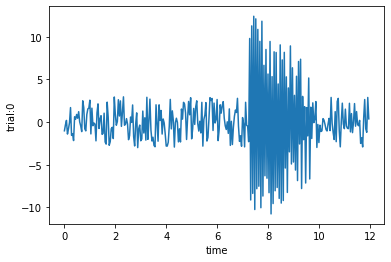

Trial 1:   [frequency, amp, gamma, t0] = [13.25, 110.0, 0.5, 3.8241626736702417]


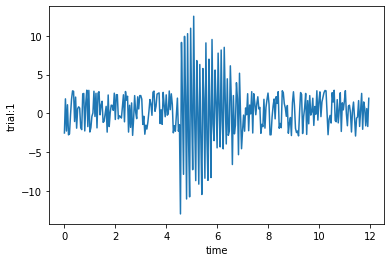

Trial 2:   [frequency, amp, gamma, t0] = [25.5, 105.0, 1.5, 5.532374016836071]


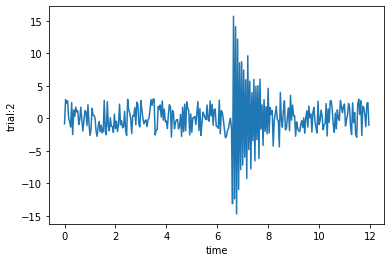

Trial 3:   [frequency, amp, gamma, t0] = [1.0, 90.0, 1.5, 6.082907827579209]


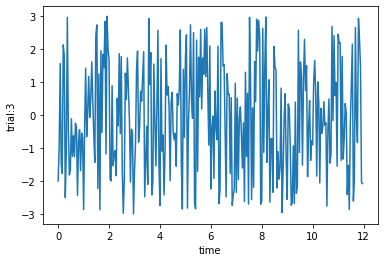

Trial 4:   [frequency, amp, gamma, t0] = [13.25, 105.0, 2.0, 1.3733259224096148]


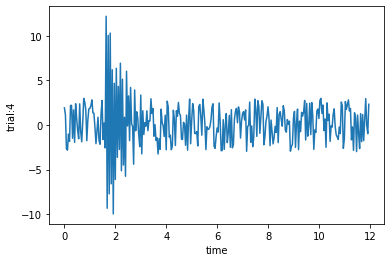

Trial 5:   [frequency, amp, gamma, t0] = [50.0, 105.0, 2.0, 4.548413609442816]


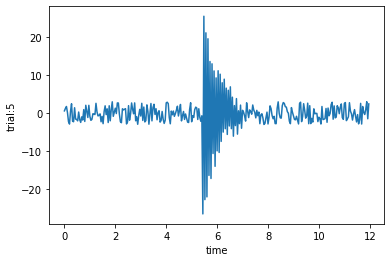

Trial 6:   [frequency, amp, gamma, t0] = [50.0, 110.0, 1.0, 4.539899356443001]


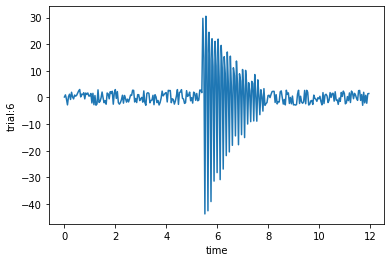

Trial 7:   [frequency, amp, gamma, t0] = [37.75, 110.0, 0.0, 0.4858465707728268]


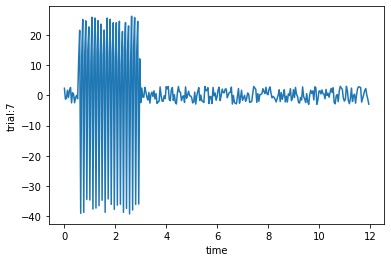

Trial 8:   [frequency, amp, gamma, t0] = [1.0, 90.0, 2.0, 1.845152511820583]


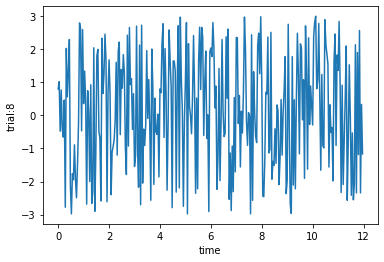

Trial 9:   [frequency, amp, gamma, t0] = [50.0, 100.0, 0.0, 6.58895370545686]


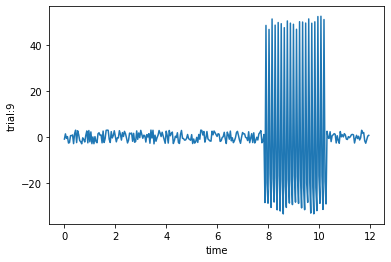

Trial 10:   [frequency, amp, gamma, t0] = [37.75, 100.0, 0.5, 5.537312881628751]


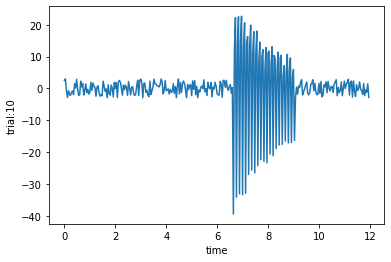

Trial 11:   [frequency, amp, gamma, t0] = [37.75, 100.0, 1.5, 0.9793058842246802]


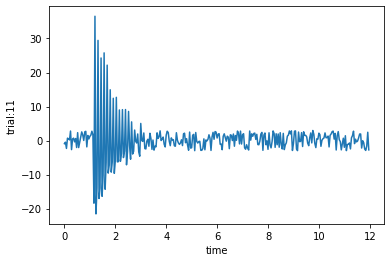

Trial 12:   [frequency, amp, gamma, t0] = [13.25, 90.0, 0.5, 1.6977572365303484]


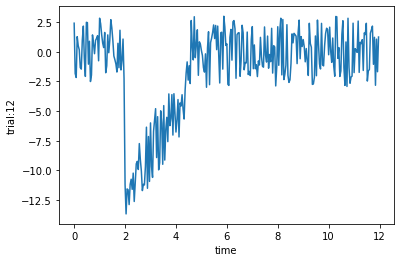

Trial 13:   [frequency, amp, gamma, t0] = [13.25, 110.0, 0.0, 0.14140249905047764]


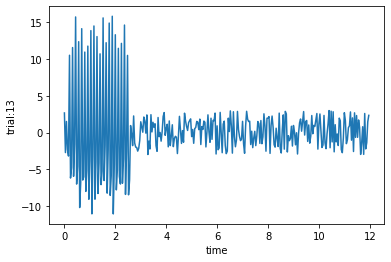

Trial 14:   [frequency, amp, gamma, t0] = [25.5, 90.0, 0.5, 2.8671068216151916]


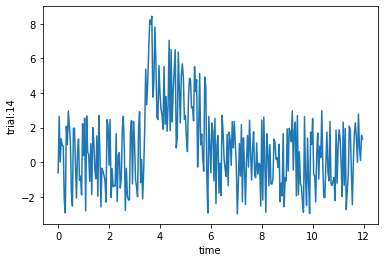

Trial 15:   [frequency, amp, gamma, t0] = [1.0, 110.0, 1.0, 6.717929031311284]


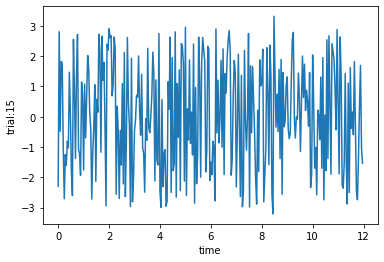

Trial 16:   [frequency, amp, gamma, t0] = [25.5, 100.0, 2.0, 1.149917166121802]


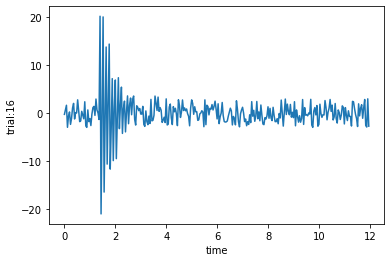

Trial 17:   [frequency, amp, gamma, t0] = [50.0, 110.0, 1.5, 5.562192172305652]


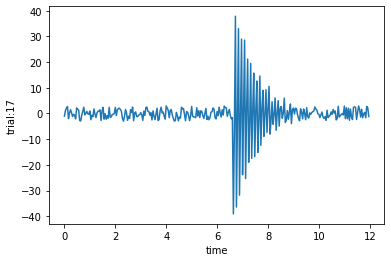

Trial 18:   [frequency, amp, gamma, t0] = [50.0, 90.0, 1.0, 7.654923191531413]


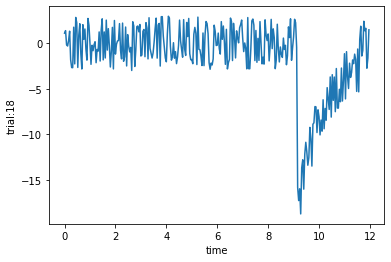

Trial 19:   [frequency, amp, gamma, t0] = [13.25, 105.0, 0.0, 0.6451349624103635]


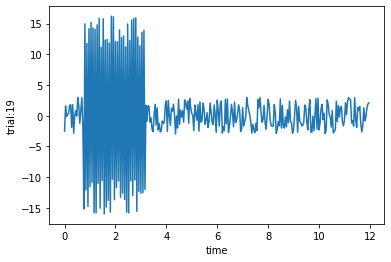

Trial 20:   [frequency, amp, gamma, t0] = [37.75, 95.0, 1.5, 4.76493104741944]


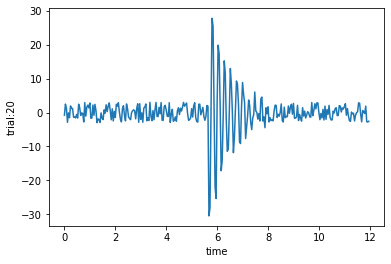

Trial 21:   [frequency, amp, gamma, t0] = [50.0, 90.0, 1.5, 6.126809740285727]


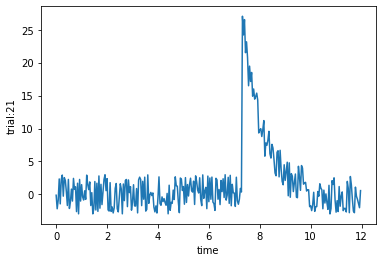

Trial 22:   [frequency, amp, gamma, t0] = [1.0, 110.0, 0.0, 2.0866216599443614]


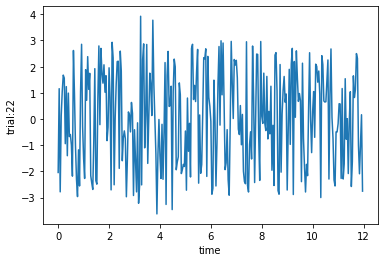

Trial 23:   [frequency, amp, gamma, t0] = [50.0, 95.0, 0.5, 0.9036022153981635]


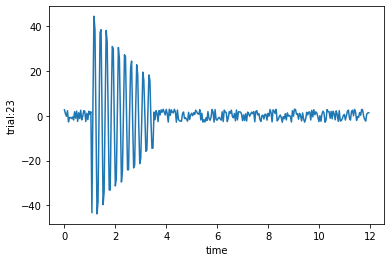

Trial 24:   [frequency, amp, gamma, t0] = [25.5, 110.0, 0.5, 5.127072357644224]


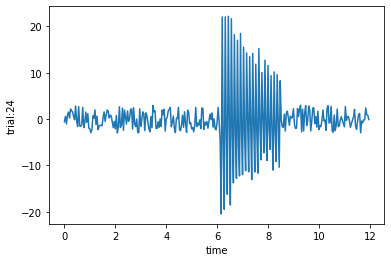

Trial 25:   [frequency, amp, gamma, t0] = [37.75, 105.0, 1.5, 4.89332109604672]


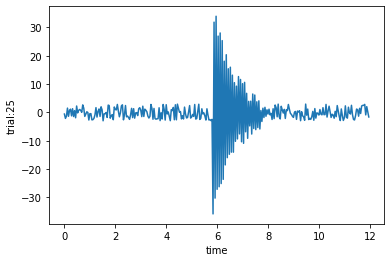

Trial 26:   [frequency, amp, gamma, t0] = [50.0, 95.0, 2.0, 7.880559375081419]


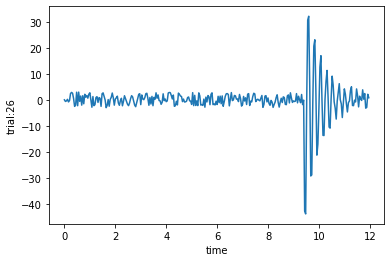

Trial 27:   [frequency, amp, gamma, t0] = [13.25, 90.0, 2.0, 3.6546793036751763]


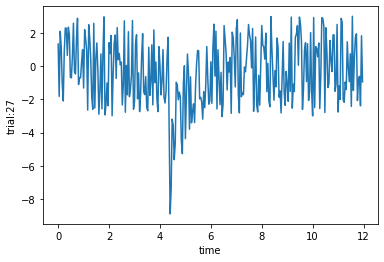

Trial 28:   [frequency, amp, gamma, t0] = [25.5, 95.0, 1.0, 6.716878960403721]


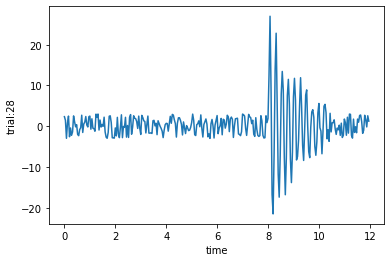

Trial 29:   [frequency, amp, gamma, t0] = [1.0, 95.0, 1.0, 1.598190701039388]


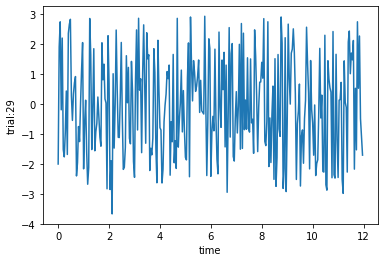

Trial 30:   [frequency, amp, gamma, t0] = [13.25, 95.0, 0.0, 2.230925840779441]


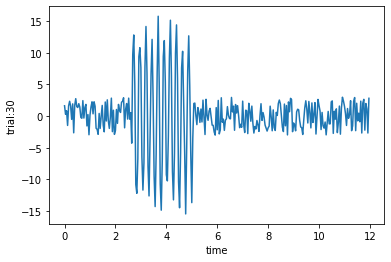

Trial 31:   [frequency, amp, gamma, t0] = [13.25, 110.0, 1.0, 6.872218281449129]


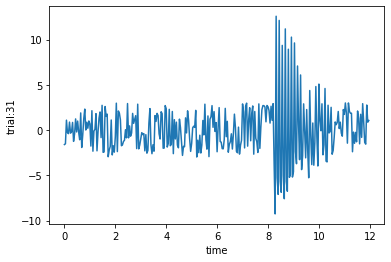

Trial 32:   [frequency, amp, gamma, t0] = [13.25, 95.0, 0.5, 1.019466179517825]


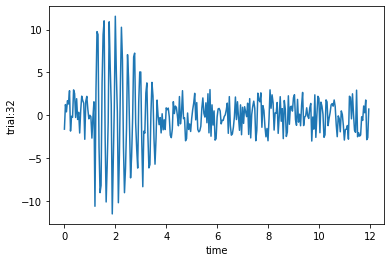

Trial 33:   [frequency, amp, gamma, t0] = [50.0, 110.0, 2.0, 1.6081418813524442]


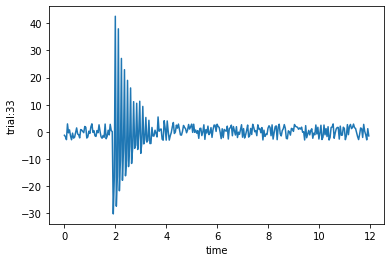

Trial 34:   [frequency, amp, gamma, t0] = [25.5, 105.0, 1.0, 7.826408893843342]


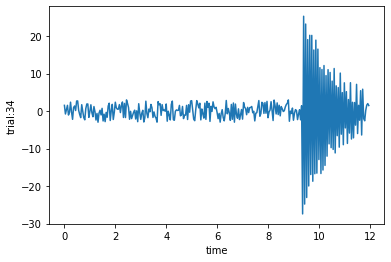

Trial 35:   [frequency, amp, gamma, t0] = [1.0, 105.0, 2.0, 4.54361732109709]


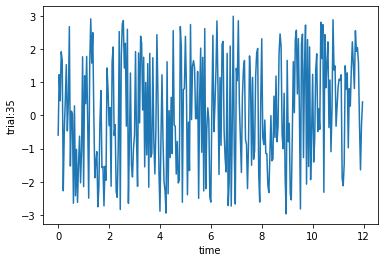

Trial 36:   [frequency, amp, gamma, t0] = [50.0, 105.0, 1.5, 3.452232201453647]


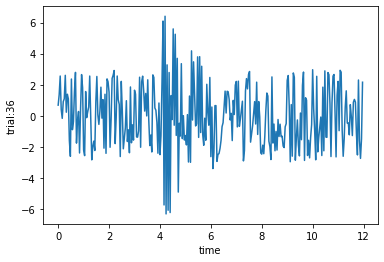

Trial 37:   [frequency, amp, gamma, t0] = [37.75, 100.0, 0.0, 7.694978781651248]


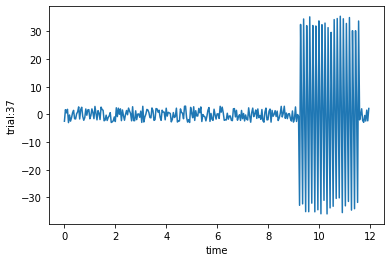

Trial 38:   [frequency, amp, gamma, t0] = [25.5, 90.0, 2.0, 7.123361901869693]


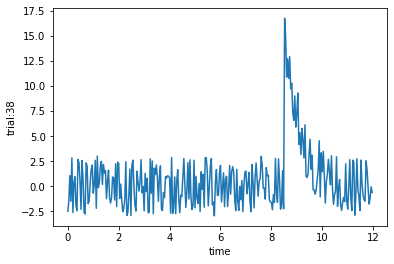

Trial 39:   [frequency, amp, gamma, t0] = [37.75, 105.0, 1.5, 1.525766865872467]


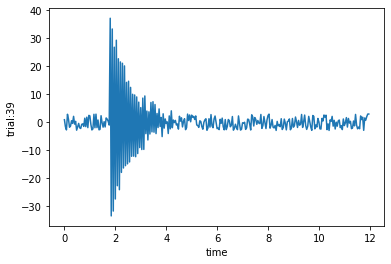

Trial 40:   [frequency, amp, gamma, t0] = [1.0, 95.0, 0.5, 5.023020774571151]


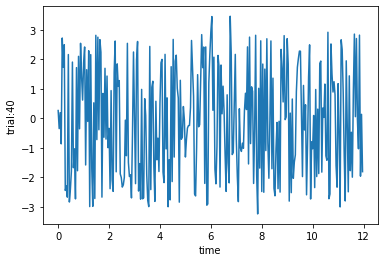

Trial 41:   [frequency, amp, gamma, t0] = [13.25, 100.0, 1.0, 7.410962283304335]


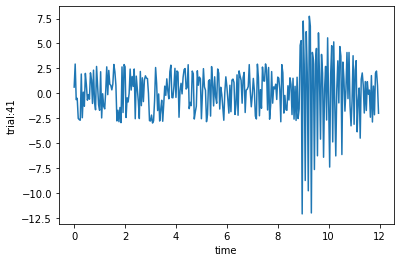

Trial 42:   [frequency, amp, gamma, t0] = [50.0, 90.0, 1.5, 7.136933327647959]


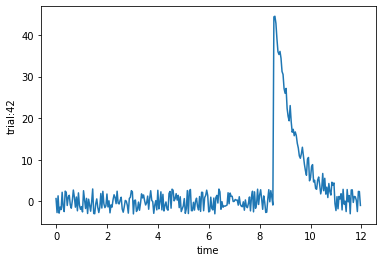

Trial 43:   [frequency, amp, gamma, t0] = [13.25, 95.0, 1.5, 4.43539903907959]


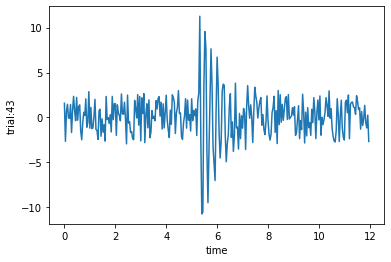

Trial 44:   [frequency, amp, gamma, t0] = [50.0, 105.0, 0.5, 3.005847614876907]


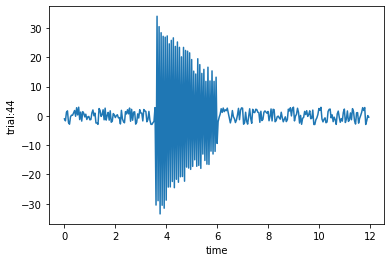

Trial 45:   [frequency, amp, gamma, t0] = [1.0, 105.0, 0.0, 5.202869342244462]


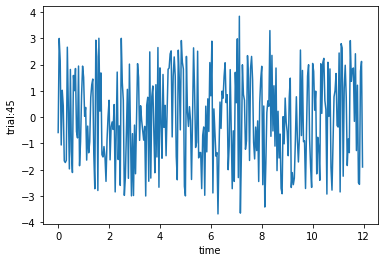

Trial 46:   [frequency, amp, gamma, t0] = [13.25, 90.0, 2.0, 6.700442996103345]


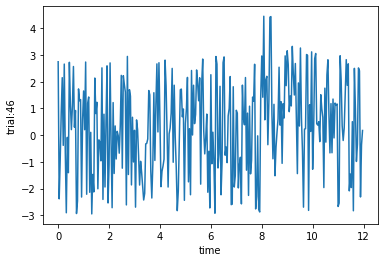

Trial 47:   [frequency, amp, gamma, t0] = [13.25, 95.0, 1.0, 0.828653258049699]


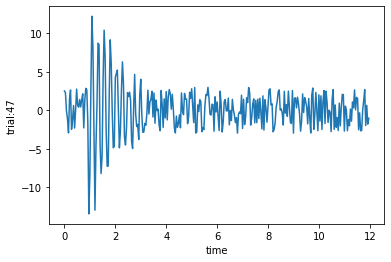

Trial 48:   [frequency, amp, gamma, t0] = [13.25, 95.0, 0.5, 2.7527977916080753]


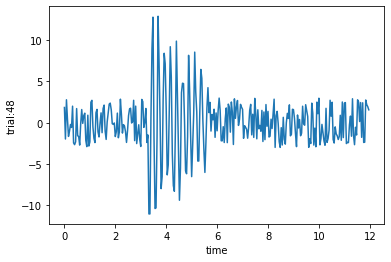

Trial 49:   [frequency, amp, gamma, t0] = [37.75, 105.0, 1.0, 0.9553772438726149]


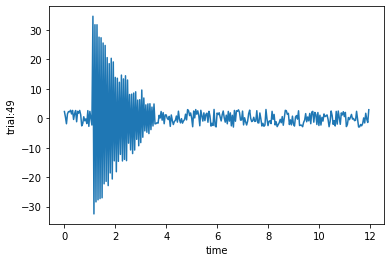

Trial 50:   [frequency, amp, gamma, t0] = [37.75, 105.0, 1.0, 6.974154237841916]


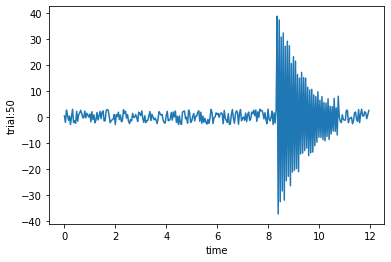

Trial 51:   [frequency, amp, gamma, t0] = [25.5, 105.0, 1.5, 5.977450628422118]


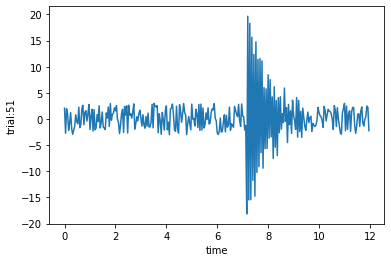

Trial 52:   [frequency, amp, gamma, t0] = [25.5, 100.0, 0.5, 6.898879815109535]


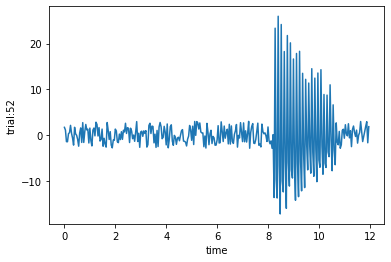

Trial 53:   [frequency, amp, gamma, t0] = [50.0, 105.0, 0.5, 2.3108961329076445]


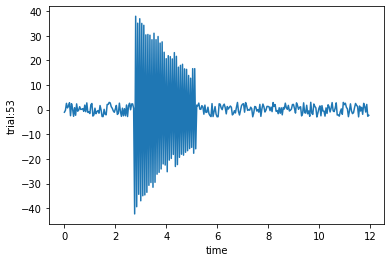

Trial 54:   [frequency, amp, gamma, t0] = [50.0, 95.0, 1.5, 4.990893119953921]


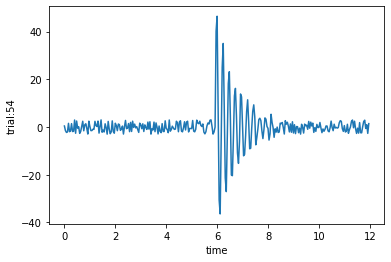

Trial 55:   [frequency, amp, gamma, t0] = [37.75, 95.0, 2.0, 0.42159754698359375]


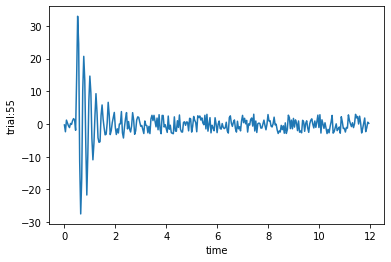

Trial 56:   [frequency, amp, gamma, t0] = [25.5, 90.0, 0.5, 7.995862742176099]


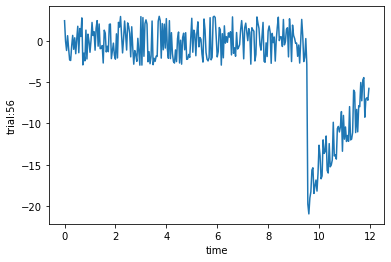

Trial 57:   [frequency, amp, gamma, t0] = [50.0, 105.0, 1.5, 3.470054112563645]


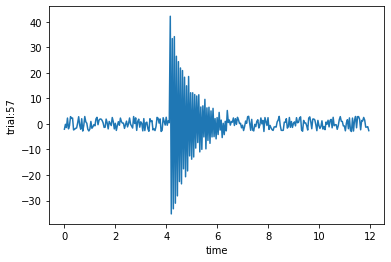

Trial 58:   [frequency, amp, gamma, t0] = [13.25, 90.0, 1.0, 6.712966311619505]


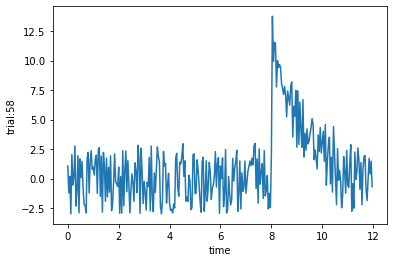

Trial 59:   [frequency, amp, gamma, t0] = [37.75, 110.0, 2.0, 2.8469265724169137]


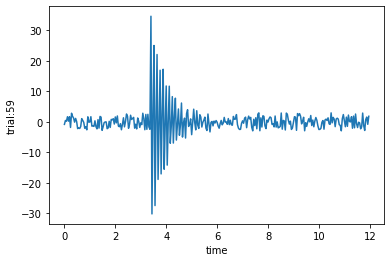

Trial 60:   [frequency, amp, gamma, t0] = [13.25, 100.0, 1.0, 5.509973643492868]


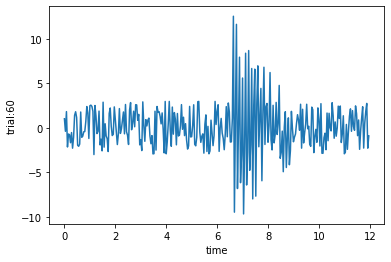

Trial 61:   [frequency, amp, gamma, t0] = [13.25, 100.0, 1.5, 4.58206456328118]


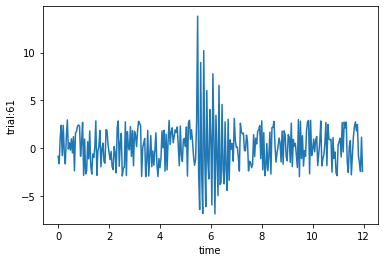

Trial 62:   [frequency, amp, gamma, t0] = [13.25, 105.0, 0.5, 0.7825677595386118]


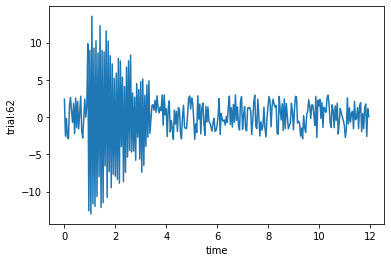

Trial 63:   [frequency, amp, gamma, t0] = [25.5, 90.0, 0.5, 0.49108811969187993]


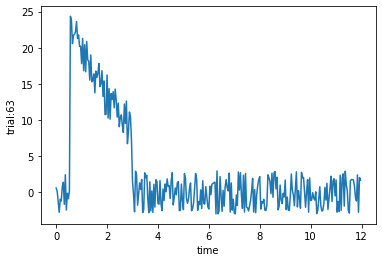

Trial 64:   [frequency, amp, gamma, t0] = [25.5, 100.0, 0.0, 5.736618470335112]


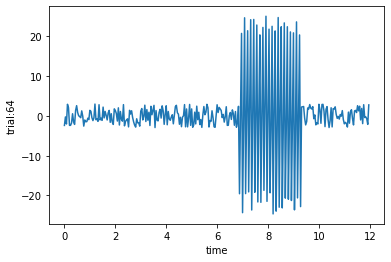

Trial 65:   [frequency, amp, gamma, t0] = [25.5, 90.0, 1.5, 4.77886691523549]


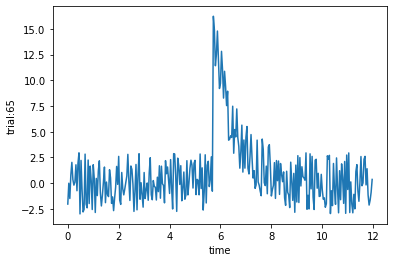

Trial 66:   [frequency, amp, gamma, t0] = [37.75, 90.0, 1.0, 0.43055813231026185]


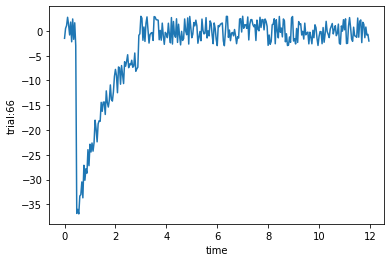

Trial 67:   [frequency, amp, gamma, t0] = [13.25, 110.0, 1.0, 1.6013297378734759]


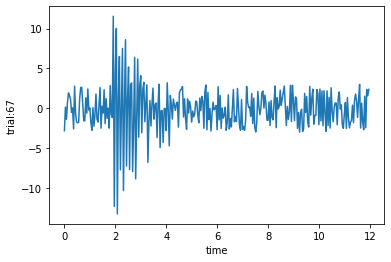

Trial 68:   [frequency, amp, gamma, t0] = [1.0, 100.0, 2.0, 3.396000107156757]


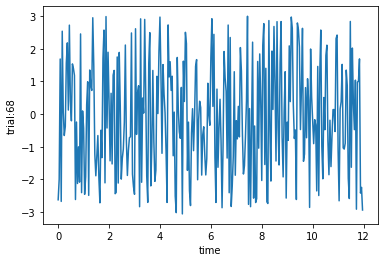

Trial 69:   [frequency, amp, gamma, t0] = [1.0, 90.0, 0.5, 0.11775678811158574]


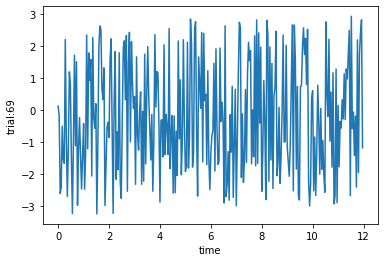

Trial 70:   [frequency, amp, gamma, t0] = [25.5, 90.0, 0.0, 7.951542632702477]


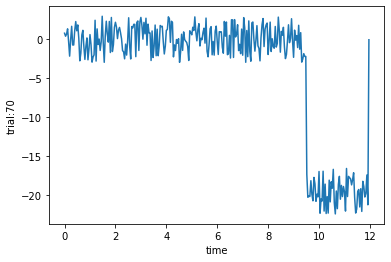

Trial 71:   [frequency, amp, gamma, t0] = [13.25, 100.0, 2.0, 0.8371102251136655]


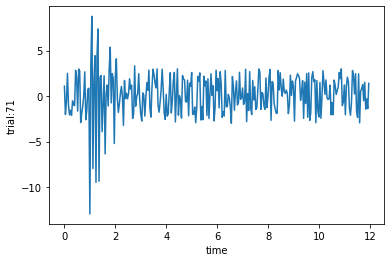

Trial 72:   [frequency, amp, gamma, t0] = [37.75, 110.0, 1.0, 3.602952099088145]


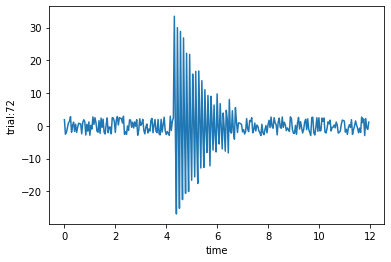

Trial 73:   [frequency, amp, gamma, t0] = [25.5, 100.0, 1.5, 3.4274168862294205]


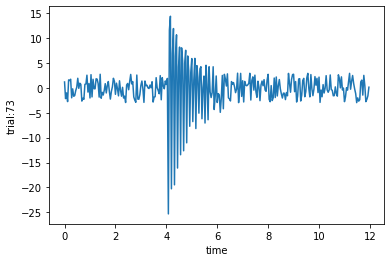

Trial 74:   [frequency, amp, gamma, t0] = [13.25, 100.0, 1.0, 4.711612045388474]


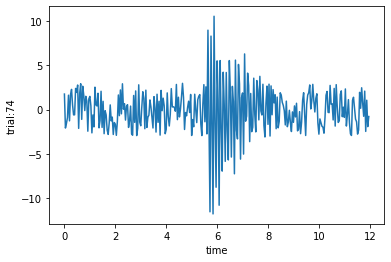

Trial 75:   [frequency, amp, gamma, t0] = [37.75, 90.0, 0.5, 6.34247131187924]


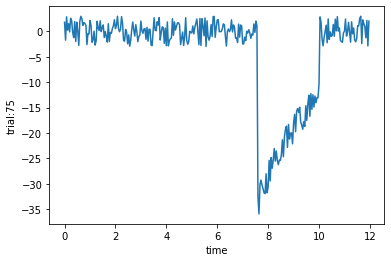

Trial 76:   [frequency, amp, gamma, t0] = [37.75, 95.0, 0.5, 0.21988422953611853]


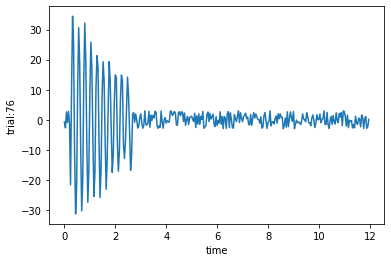

Trial 77:   [frequency, amp, gamma, t0] = [25.5, 90.0, 2.0, 3.589034638561013]


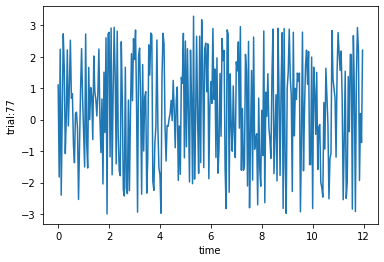

Trial 78:   [frequency, amp, gamma, t0] = [25.5, 100.0, 0.0, 1.0866660001555992]


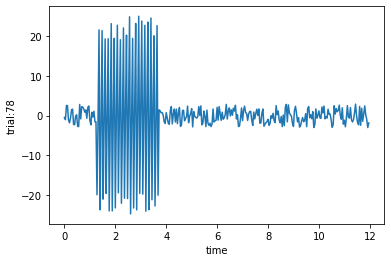

Trial 79:   [frequency, amp, gamma, t0] = [50.0, 105.0, 2.0, 4.932909148064373]


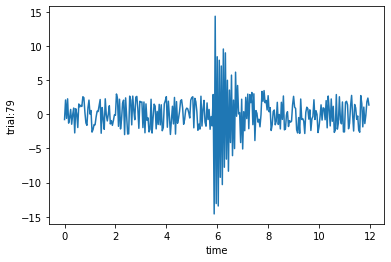

Trial 80:   [frequency, amp, gamma, t0] = [50.0, 90.0, 2.0, 0.8328797089985027]


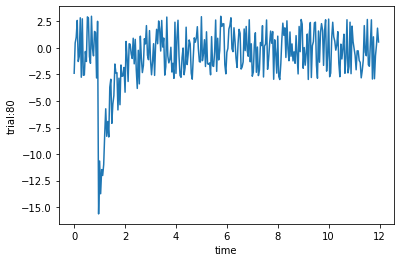

Trial 81:   [frequency, amp, gamma, t0] = [25.5, 95.0, 0.0, 5.3585171482545455]


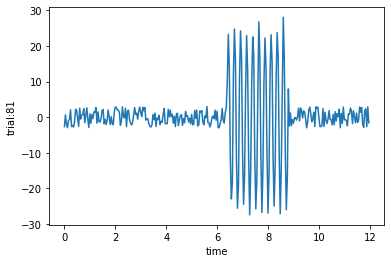

Trial 82:   [frequency, amp, gamma, t0] = [13.25, 105.0, 0.5, 5.615131076046665]


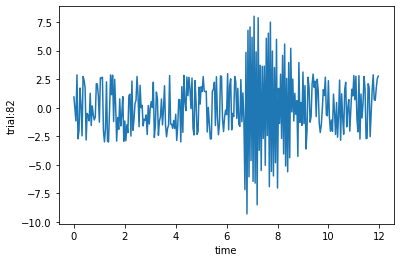

Trial 83:   [frequency, amp, gamma, t0] = [50.0, 100.0, 0.5, 7.148881873261056]


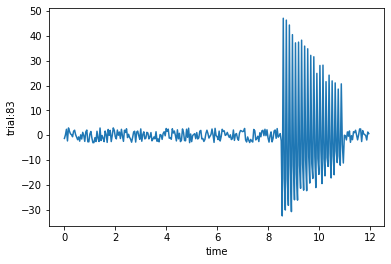

Trial 84:   [frequency, amp, gamma, t0] = [50.0, 90.0, 0.0, 2.9213735397586715]


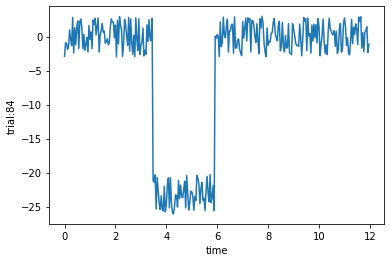

Trial 85:   [frequency, amp, gamma, t0] = [1.0, 105.0, 0.0, 0.8251027099776094]


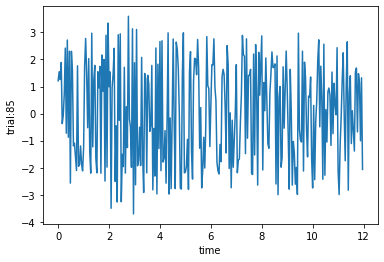

Trial 86:   [frequency, amp, gamma, t0] = [1.0, 110.0, 0.5, 4.333410227437047]


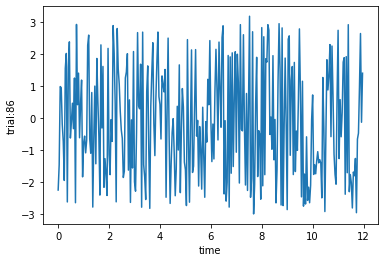

Trial 87:   [frequency, amp, gamma, t0] = [25.5, 90.0, 0.5, 1.2882197066822512]


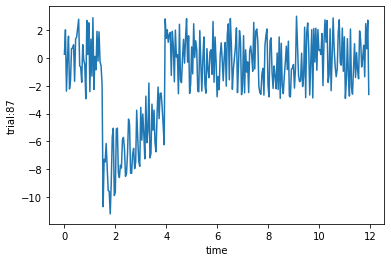

Trial 88:   [frequency, amp, gamma, t0] = [13.25, 110.0, 1.0, 3.2610172843863]


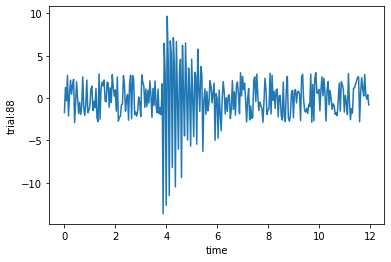

Trial 89:   [frequency, amp, gamma, t0] = [25.5, 110.0, 0.0, 3.593307412838654]


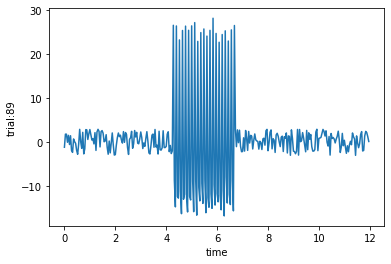

Trial 90:   [frequency, amp, gamma, t0] = [1.0, 105.0, 0.0, 1.2210908903210722]


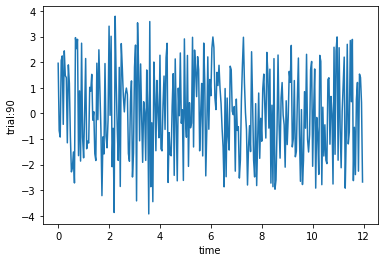

Trial 91:   [frequency, amp, gamma, t0] = [13.25, 100.0, 1.5, 6.001820429555539]


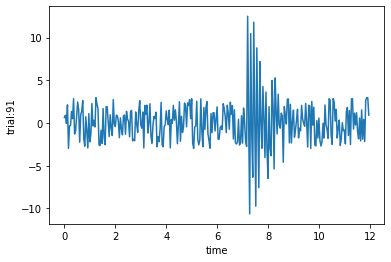

Trial 92:   [frequency, amp, gamma, t0] = [50.0, 110.0, 1.5, 2.44966119658742]


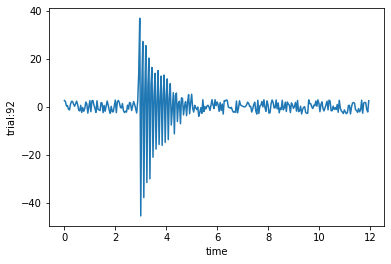

Trial 93:   [frequency, amp, gamma, t0] = [13.25, 100.0, 1.5, 1.5704833648600598]


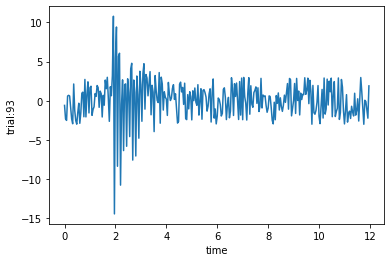

Trial 94:   [frequency, amp, gamma, t0] = [50.0, 110.0, 2.0, 1.176877247016078]


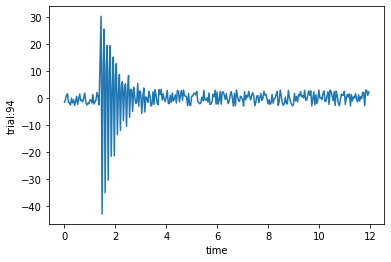

Trial 95:   [frequency, amp, gamma, t0] = [13.25, 90.0, 1.0, 1.0507799635202275]


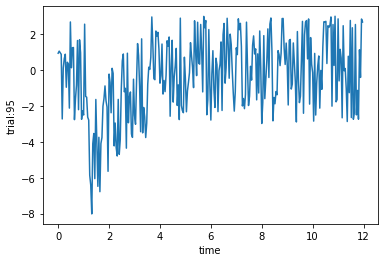

Trial 96:   [frequency, amp, gamma, t0] = [13.25, 110.0, 1.5, 3.8904542716234465]


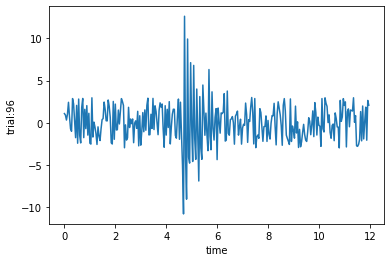

Trial 97:   [frequency, amp, gamma, t0] = [25.5, 95.0, 0.5, 2.924246027214525]


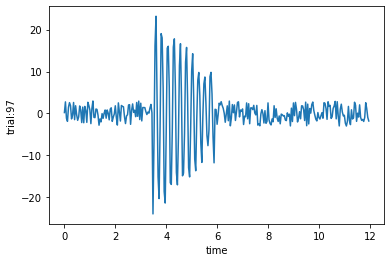

Trial 98:   [frequency, amp, gamma, t0] = [25.5, 95.0, 1.5, 5.852414062458591]


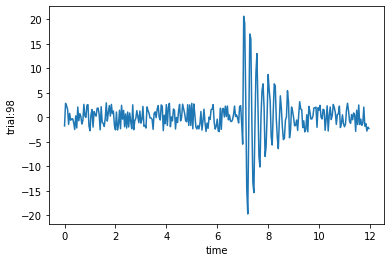

Trial 99:   [frequency, amp, gamma, t0] = [13.25, 90.0, 1.0, 5.834626570190213]


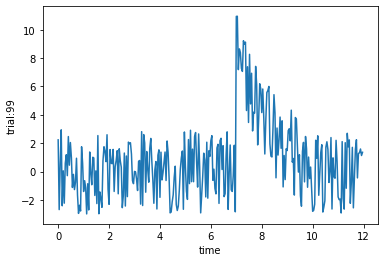

In [792]:
from matplotlib import pyplot as plt
%matplotlib inline

xaxis=[10/x.N*j for j in range(OS.N)] 
for i in range(OS.trials):
    print("Trial "+str(i)+":   [frequency, amp, gamma, t0] = "+str(OS.output[i][0]))
    plt.plot(xaxis, OS.output[i][1])
    plt.xlabel("time")
    plt.ylabel("trial:" +str(i))
    plt.show()

In [786]:
#builds rho statistic
y=OS.rho()

In [793]:
#performs modulation/ bg-fg value finding on rho
z=OS.window(.2)

initalizing output...
t0: 6.06980828108494  T0_2D: 15
t0: 3.8241626736702417  T0_2D: 9
t0: 5.532374016836071  T0_2D: 13
t0: 6.082907827579209  T0_2D: 15
t0: 1.3733259224096148  T0_2D: 3
t0: 4.548413609442816  T0_2D: 11
t0: 4.539899356443001  T0_2D: 11
t0: 0.4858465707728268  T0_2D: 1
t0: 1.845152511820583  T0_2D: 4
t0: 6.58895370545686  T0_2D: 16
t0: 5.537312881628751  T0_2D: 13
t0: 0.9793058842246802  T0_2D: 2
t0: 1.6977572365303484  T0_2D: 4
t0: 0.14140249905047764  T0_2D: 0
t0: 2.8671068216151916  T0_2D: 7
t0: 6.717929031311284  T0_2D: 16
t0: 1.149917166121802  T0_2D: 2
t0: 5.562192172305652  T0_2D: 13
t0: 7.654923191531413  T0_2D: 19
t0: 0.6451349624103635  T0_2D: 1
t0: 4.76493104741944  T0_2D: 11
t0: 6.126809740285727  T0_2D: 15
t0: 2.0866216599443614  T0_2D: 5
t0: 0.9036022153981635  T0_2D: 2
t0: 5.127072357644224  T0_2D: 12
t0: 4.89332109604672  T0_2D: 12
t0: 7.880559375081419  T0_2D: 19
t0: 3.6546793036751763  T0_2D: 9
t0: 6.716878960403721  T0_2D: 16
t0: 1.598190701039388  T0_

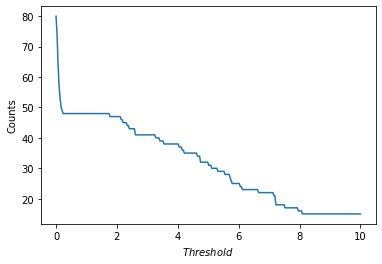

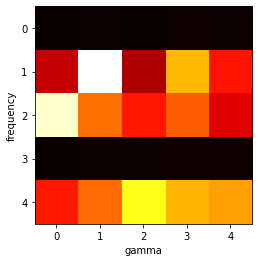

In [794]:
OS.test_plotter( 10, 300, var1=0, var2=0)


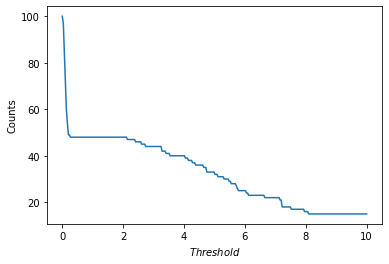

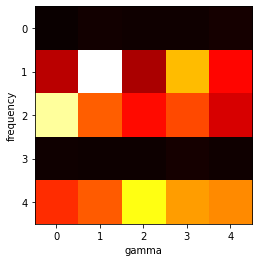

In [795]:
OS.test_plotter( 10, 300, var1=0, var2=0,bg_test=False)

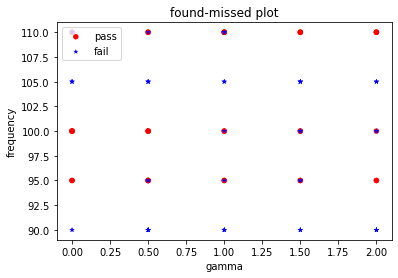

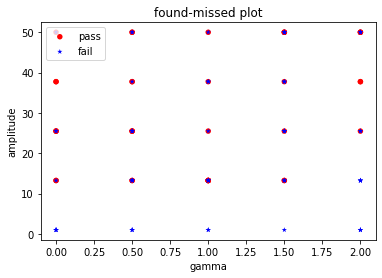

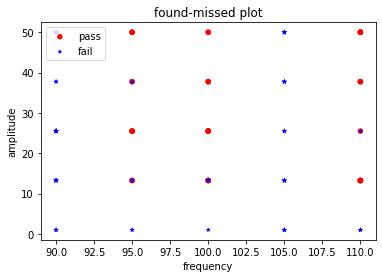

In [796]:
#scatter plot of fails & passes given threshold t

# Amplitude vs. gamma
OS.Scatter_plotter( 4, 2, 1)

# Amplitude vs. frequency
OS.Scatter_plotter( 4, 2, 0)

# frequency vs. gamaa
OS.Scatter_plotter( 3, 1, 0)

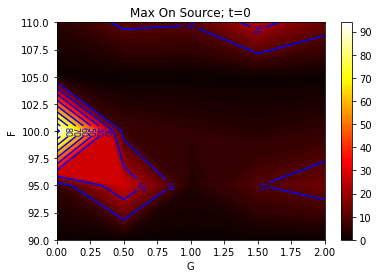

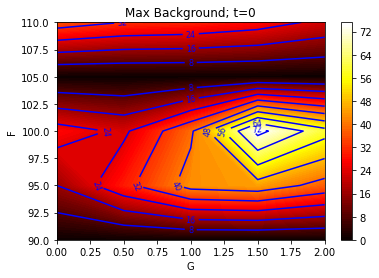

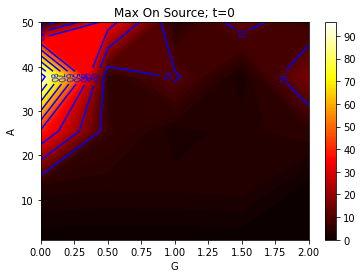

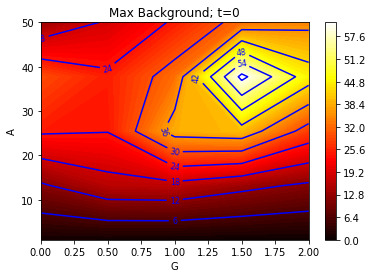

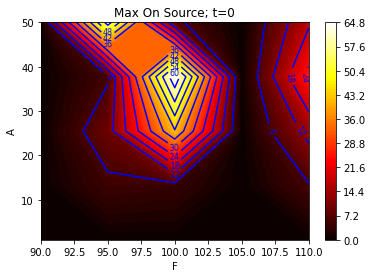

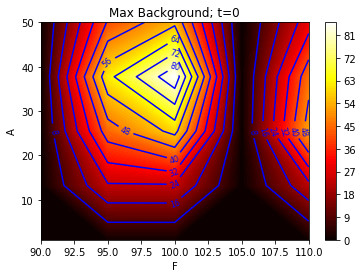

In [797]:
#heat plot of 
#     1. average max onsource rho, over trials
#     2. max background rho, over templates

# Amplitude vs. gamma
OS.heatmap(2,1,0)


# Amplitude vs. frequency
OS.heatmap(2,0,0)

# frequency vs. gamaa
OS.heatmap(1,0,0)

# Errors
Need-fixing:
<br>
<br>Completed:
- ~~Error 1: The json does not save~~
    - the old error was fixed; The issue was due to trying to store np arrays inside the the json file without casting them to lists first. Now it seems the only issue is a jupyter thing its self; it won't output dictionaries after a certain size. However, it works fine from a personal laptop terminal. For the moment, it is commeneted out though, just to avoid saving unnecessary files during debugging

- ~~Error 2: lists are coming out the wrong size~~ 
    - This was because of a bunch approximations I haphazardly made in 'waveform' ; after cleaning up the function, everything is now coming out the correct size

- ~~Error 3: windowing produces errors given odd half-window sizes~~
    - This was due to 'throwing away' the end components of the modulated statistic within the modulation function; the result was shorter than expected outputs, resulting in array off-by-one errors in 'window'

- ~~Error 4: Graphs look funny~~
    - turns out this wasn't an error at all; the graphs just looked funny because the resolution was low

# To-do's: 
- todo 1: update commenting
    - the commenting in shoddy and confusing in  a lot of places -- go back and explain what you're donig
- todo 2: clean up attribute use
    - theres a lot of variables/ attributes that are often randomly rederived or named poorly; this could use some cleaning too
- todo 3: extra plots
    - now that everything seems to be running, make some prettier plots

# TEST-AREA


In [ ]:
%%timeit
x=OnSource(10, 10, 10, 4, 10, 4, 0.3, 1, N_t=250)
#N_A, N_g, N_f, t0_tf, T, b, D, trials, N_t